# CNN+Embed

# Adjust Parameters and test text

ข้อความที่ทดสอบ ความยาวไม่เกิน 165 ตัวอักษร

In [353]:
test_text = "ส่งผลต่อการพัฒนาเศรษฐกิจโดยตรง"

In [354]:
prob = 0.5

In [355]:
#model parameter
epochs=5
batch_size=5

In [356]:
#CNN Hyper Parameter
recurrent_units=128
dropout_rate=0.3
recurrent_dropout_rate=0.3
dense_size=64
kernel_size=10

In [357]:
embed_size = 100 #ขนาดของ vector embed ของ char แต่ละตัว

# Start

In [358]:
import tensorflow as tf

In [359]:
import keras

In [360]:
import pandas as pd
import numpy as np

In [361]:
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints
from keras.models import Model, load_model
from keras.layers import Dense, Embedding, Input, concatenate
from keras.layers import LSTM, Bidirectional, Dropout, SpatialDropout1D, AveragePooling1D, GlobalAveragePooling1D, TimeDistributed, Masking, Lambda 
from keras.layers import GRU, MaxPooling1D, Conv1D, GlobalMaxPool1D, Activation, Add, Flatten, BatchNormalization
from keras.layers import CuDNNGRU, CuDNNLSTM
from keras.layers import Flatten, Dense, Reshape
from keras.optimizers import RMSprop, Adam, Nadam
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

In [362]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [363]:
from keras.utils.np_utils import to_categorical

In [364]:
from keras.utils import to_categorical

# Import Cleaned Data

In [365]:
df = pd.read_csv("dataset_orchid_clean.csv")

In [366]:
df.head(10)

,Unnamed: 0,sentence(x),words,word_with_special_char(y),sentence_without_space(x_clean),binary(y),sentence_len,binary_len
0,0,การประชุมทางวิชาการ ครั้งที่ 1,"['การ', 'ประชุม', 'ทาง', 'วิชาการ', 'ครั้ง', '...","['การ', 'ประชุม', 'ทาง', 'วิชาการ', 'ครั้ง', '...",การประชุมทางวิชาการ ครั้งที่ 1,1001000001001000000100001000,28,28
1,1,โครงการวิจัยและพัฒนาอิเล็กทรอนิกส์และคอมพิวเตอร์,"['โครงการวิจัย', 'และ', 'พัฒนา', 'อิเล็กทรอนิก...","['โครงการวิจัย', 'และ', 'พัฒนา', 'อิเล็กทรอนิก...",โครงการวิจัยและพัฒนาอิเล็กทรอนิกส์และคอมพิวเตอร์,100000000000100100001000000000000010010000000000,48,48
2,2,ปีงบประมาณ 2531,"['ปีงบประมาณ', '2531']","['ปีงบประมาณ', '2531']",ปีงบประมาณ 2531,10000000001000,14,14
3,3,เล่ม 1,"['เล่ม', '1']","['เล่ม', '1']",เล่ม 1,10001,5,5
4,4,ศูนย์เทคโนโลยีอิเล็กทรอนิกส์และคอมพิวเตอร์แห่ง...,['ศูนย์เทคโนโลยีอิเล็กทรอนิกส์และคอมพิวเตอร์แห...,['ศูนย์เทคโนโลยีอิเล็กทรอนิกส์และคอมพิวเตอร์แห...,ศูนย์เทคโนโลยีอิเล็กทรอนิกส์และคอมพิวเตอร์แห่ง...,1000000000000000000000000000000000000000000000...,50,50
5,5,กระทรวงวิทยาศาสตร์ เทคโนโลยีและการพลังงาน,['กระทรวงวิทยาศาสตร์ เทคโนโลยีและการพลังงาน'],['กระทรวงวิทยาศาสตร์เทคโนโลยีและการพลังงาน'],กระทรวงวิทยาศาสตร์ เทคโนโลยีและการพลังงาน,1000000000000000000000000000000000000000,40,40
6,6,วันที่ 15-16 สิงหาคม 2532,"['วัน', 'ที่ 15', '<minus>', '16', 'สิงหาคม', ...","['วัน', 'ที่15', '-', '16', 'สิงหาคม', '2532']",วันที่ 15-16 สิงหาคม 2532,1001000011010000001000,22,22
7,7,ห้องประชุม ชั้น 4,"['ห้องประชุม', 'ชั้น', '4']","['ห้องประชุม', 'ชั้น', '4']",ห้องประชุม ชั้น 4,100000000010001,15,15
8,8,สาร,['สาร'],['สาร'],สาร,100,3,3
9,9,ฯพณฯ รัฐมนตรีว่าการกระทรวงวิทยาศาสตร์ เทคโนโลย...,"['ฯพณฯ', 'รัฐมนตรีว่าการ', 'กระทรวงวิทยาศาสตร์...","['ฯพณฯ', 'รัฐมนตรีว่าการ', 'กระทรวงวิทยาศาสตร์...",ฯพณฯ รัฐมนตรีว่าการกระทรวงวิทยาศาสตร์ เทคโนโลย...,1000100000000000001000000000000000000000000000...,58,58


# Split String to List of Chars

In [367]:
def split(word): 
    return [char for char in word]  

In [368]:
df['char(x)'] = df['sentence_without_space(x_clean)'].apply(split)
df['bit(y)'] = df['binary(y)'].apply(split)

In [369]:
df['len_x'] = df['char(x)'].apply(len)
df['len_y'] = df['bit(y)'].apply(len)

In [370]:
df = df[df['len_x']==df['len_y']]

In [371]:
char_x = df[['char(x)']]
bit_y = df[['bit(y)']]

In [372]:
char_x.head()

,char(x)
1,"[โ, ค, ร, ง, ก, า, ร, ว, ิ, จ, ั, ย, แ, ล, ะ, ..."
4,"[ศ, ู, น, ย, ์, เ, ท, ค, โ, น, โ, ล, ย, ี, อ, ..."
8,"[ส, า, ร]"
13,"[ซ, ึ, ่, ง, อ, ุ, ต, ส, า, ห, ก, ร, ร, ม, น, ..."
17,"[โ, ด, ย, ก, า, ร, ส, น, ั, บ, ส, น, ุ, น, ใ, ..."


In [373]:
bit_y.head()

,bit(y)
1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
4,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,"[1, 0, 0]"
13,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
17,"[1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ..."


# Convert Chars (x) to Numbers (order) then Padding

In [374]:
sequence_x = []
for i in char_x['char(x)']:
    conv = []
    for j in i:
        conv.append(ord(j))
    sequence_x.append(conv)

In [375]:
x = pad_sequences(sequence_x,padding='post')

In [376]:
x

array([[3650, 3588, 3619, ...,    0,    0,    0],
       [3624, 3641, 3609, ...,    0,    0,    0],
       [3626, 3634, 3619, ...,    0,    0,    0],
       ...,
       [3649, 3621, 3632, ...,    0,    0,    0],
       [3607, 3635, 3651, ...,    0,    0,    0],
       [3592, 3632, 3617, ...,    0,    0,    0]])

In [377]:
x.shape

(4942, 165)

# Padding Binary (y)

In [378]:
sequence_y = []
for i in bit_y['bit(y)']:
    conc = []
    for j in i:
        conc.append(j)
    sequence_y.append(conc)

In [379]:
y = pad_sequences(sequence_y,padding='post')

In [380]:
y

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0]])

In [381]:
y.shape

(4942, 165)

# Split Data to Train/Test

In [382]:
from sklearn.model_selection import train_test_split

In [383]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1000)

In [384]:
x_train

array([[3648, 3614, 3639, ...,    0,    0,    0],
       [3649, 3621, 3632, ...,    0,    0,    0],
       [3648, 3614, 3639, ...,    0,    0,    0],
       ...,
       [3650, 3604, 3618, ...,    0,    0,    0],
       [3648, 3611, 3655, ...,    0,    0,    0],
       [3588, 3621, 3639, ...,    0,    0,    0]])

In [385]:
y_train

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [386]:
print("shape")
print("x_train : ",x_train.shape,"y_train : ",y_train.shape)
print("x_test : ",x_test.shape,"y_test : ",y_test.shape)

shape
x_train :  (3706, 165) y_train :  (3706, 165)
x_test :  (1236, 165) y_test :  (1236, 165)


In [387]:
#find distinct char to set max feature of embed
distinct_char = []
for i in char_x['char(x)']:
    conc = []
    for j in i:
        conc.append(j)
    distinct_char.append(conc)

distinct_list = []
for i in distinct_char:
    for j in i:
        distinct_list.append(j)
distinct_set = set(distinct_list)

len(distinct_set)

89

# Train CNN+Embed

In [388]:
#CNN Hyper Parameter
maxlen=165 
nb_classes=2
max_features = len(distinct_set)

In [389]:
def cnn_emb(maxlen, embed_size, recurrent_units, dropout_rate, recurrent_dropout_rate, dense_size, nb_classes):
    inp = Input(shape=(maxlen, ))
    input_layer = Input(shape=(maxlen, 1), )
    x = Embedding(max_features, embed_size, trainable=False)(inp)
    x = Dropout(dropout_rate)(input_layer) 
    x = Conv1D(filters=recurrent_units, kernel_size=kernel_size, padding='same', activation='relu')(x)
#    x = MaxPooling1D(pool_size=2)(x)
#    x = Conv1D(filters=recurrent_units, kernel_size=2, padding='same', activation='relu')(x)
#    x = MaxPooling1D(pool_size=2)(x)
#    x = Conv1D(filters=recurrent_units, kernel_size=2, padding='same', activation='relu')(x)
#    x = MaxPooling1D(pool_size=2)(x)
#    x = GRU(recurrent_units)(x)
#    x = Dropout(dropout_rate)(x)
    x = Dense(dense_size, activation="relu")(x)
    x = Dense(nb_classes, activation="sigmoid")(x)
    model = Model(inputs=input_layer, outputs=x)
    model.summary()  
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model 

In [390]:
model_cnn_emb = cnn_emb(maxlen=maxlen,embed_size=embed_size,recurrent_units=recurrent_units,dropout_rate=dropout_rate,recurrent_dropout_rate=recurrent_dropout_rate, dense_size=dense_size,nb_classes=nb_classes)

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 165, 1)            0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 165, 1)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 165, 128)          1408      
_________________________________________________________________
dense_19 (Dense)             (None, 165, 64)           8256      
_________________________________________________________________
dense_20 (Dense)             (None, 165, 2)            130       
Total params: 9,794
Trainable params: 9,794
Non-trainable params: 0
_________________________________________________________________


# Reshape to array to fit model

In [391]:
from keras.utils import to_categorical
y_train_cnn = to_categorical(y_train)
y_test_cnn = to_categorical(y_test)

In [392]:
# y_train_cnn = y_train.reshape(y_train.shape[0],y_train.shape[1],1)
# y_test_cnn = y_test.reshape(y_test.shape[0],y_test.shape[1],1)

In [393]:
x_train_cnn = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test_cnn = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [394]:
print("shape")
print("x_train_cnn : ",x_train_cnn.shape,"y_train_cnn : ",y_train_cnn.shape)
print("x_test_cnn : ",x_test_cnn.shape,"y_test_cnn : ",y_test_cnn.shape)

shape
x_train_cnn :  (3706, 165, 1) y_train_cnn :  (3706, 165, 2)
x_test_cnn :  (1236, 165, 1) y_test_cnn :  (1236, 165, 2)


# Fit model CNN

In [395]:
CNN = model_cnn_emb.fit(x_train_cnn, y_train_cnn,
                    epochs=epochs,
                    verbose=False,
                    validation_data=(x_test_cnn, y_test_cnn),
                    batch_size=batch_size)

In [396]:
loss, accuracy = model_cnn_emb.evaluate(x_train_cnn, y_train_cnn, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_cnn_emb.evaluate(x_test_cnn, y_test_cnn, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9460
Testing Accuracy:  0.9457


In [397]:
y_prob_cnn = model_cnn_emb.predict(x_test_cnn)

In [398]:
y_pred_cnn = np.where(y_prob_cnn > prob, 1, 0)

In [399]:
y_prob_cnn.shape

(1236, 165, 2)

In [400]:
y_pred_cnn = np.argmax(y_pred_cnn, axis=-1)

In [401]:
y_pred_cnn.shape

(1236, 165)

In [402]:
# y_prob_cnn_list = np.squeeze(y_prob_cnn).flatten().tolist()

In [403]:
# len(y_prob_cnn_list)

In [404]:
# y_pred_cnn = np.where(y_prob_cnn > prob, 1, 0)
# y_pred_cnn = np.squeeze(y_pred_cnn)

In [405]:
y_test

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [406]:
y_pred_cnn

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [407]:
y_test_list = y_test.flatten().tolist()
y_pred_cnn_list = y_pred_cnn.flatten().tolist()

In [408]:
matrix_cnn = confusion_matrix(y_test_list, y_pred_cnn_list)

In [409]:
matrix_cnn

array([[192593,      0],
       [ 11124,    223]], dtype=int64)

In [410]:
print('accuracy_score : ',accuracy_score(y_test_list, y_pred_cnn_list))
print('precision_score : ',precision_score(y_test_list, y_pred_cnn_list))
print('recall_score : ',recall_score(y_test_list, y_pred_cnn_list))
print('f1_score : ',f1_score(y_test_list, y_pred_cnn_list))

accuracy_score :  0.9454545454545454
precision_score :  1.0
recall_score :  0.01965277165770688
f1_score :  0.03854796888504754


In [411]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training accuracy')
    plt.plot(x, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

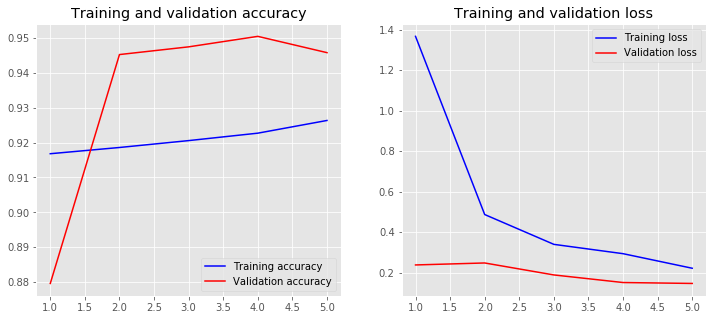

In [412]:
plot_history(CNN)

In [413]:
# list all data in history
print(CNN.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


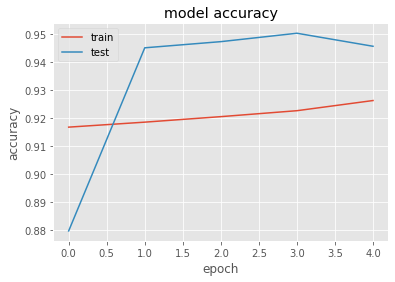

In [414]:
# summarize history for accuracy
plt.plot(CNN.history['accuracy'])
plt.plot(CNN.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

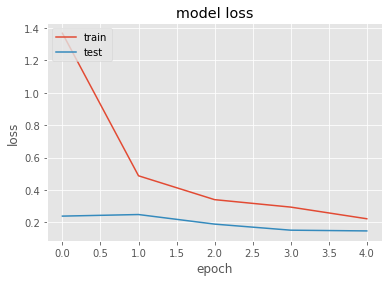

In [415]:
# summarize history for loss
plt.plot(CNN.history['loss'])
plt.plot(CNN.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Predict test text

In [416]:
test_text = test_text.replace(" ", "")

In [417]:
char_test = split(test_text)
print(char_test)
print(len(char_test))

['ส', '่', 'ง', 'ผ', 'ล', 'ต', '่', 'อ', 'ก', 'า', 'ร', 'พ', 'ั', 'ฒ', 'น', 'า', 'เ', 'ศ', 'ร', 'ษ', 'ฐ', 'ก', 'ิ', 'จ', 'โ', 'ด', 'ย', 'ต', 'ร', 'ง']
30


In [418]:
sequence_test = []
for i in char_test:
    sequence_test.append(ord(i))
    
#test_ = pad_sequences(sequence_test,padding='post', maxlen = maxlen)

print(sequence_test)
#print(test_.shape)

[3626, 3656, 3591, 3612, 3621, 3605, 3656, 3629, 3585, 3634, 3619, 3614, 3633, 3602, 3609, 3634, 3648, 3624, 3619, 3625, 3600, 3585, 3636, 3592, 3650, 3604, 3618, 3605, 3619, 3591]


In [419]:
for i in range(maxlen - len(sequence_test)):
   sequence_test.append(0)

In [420]:
sequence_test = np.array(sequence_test)

In [421]:
test_text_cnn = sequence_test.reshape(1,sequence_test.shape[0],1)

In [422]:
prob_test_cnn = model_cnn_emb.predict(test_text_cnn)

In [423]:
prob_test_cnn.shape

(1, 165, 2)

In [424]:
pred_test_cnn = np.where(prob_test_cnn > prob, 1, 0)

In [425]:
pred_test_cnn = np.argmax(pred_test_cnn, axis=-1)
pred_test_cnn

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int64)

In [426]:
# pred_test_cnn = np.where(prob_test_cnn > prob, 1, 0)
# pred_test_cnn = np.squeeze(pred_test_cnn)

In [427]:
pred_test_cnn_list = pred_test_cnn.flatten().tolist()

In [428]:
test_text_cnn.shape

(1, 165, 1)

In [429]:
def word_seg(x,y):
    cut = []
    w = ''
    for i in range(len(x)):
        print(i,x[i],y[i])
        if i>0 and y[i]==1:
            cut.append(w)
            w = ''
            w = w+x[i]
        else:
            w = w+x[i]
    cut.append(w)
    print(cut)
    return(cut)

In [430]:
test_result = word_seg(char_test,pred_test_cnn_list)

0 ส 0
1 ่ 0
2 ง 0
3 ผ 0
4 ล 0
5 ต 0
6 ่ 0
7 อ 0
8 ก 0
9 า 0
10 ร 0
11 พ 0
12 ั 0
13 ฒ 0
14 น 0
15 า 0
16 เ 0
17 ศ 0
18 ร 0
19 ษ 0
20 ฐ 0
21 ก 0
22 ิ 0
23 จ 0
24 โ 0
25 ด 0
26 ย 0
27 ต 0
28 ร 0
29 ง 0
['ส่งผลต่อการพัฒนาเศรษฐกิจโดยตรง']


In [431]:
print('test_text : ',test_text)
print('result_cnn : ',test_result)

test_text :  ส่งผลต่อการพัฒนาเศรษฐกิจโดยตรง
result_cnn :  ['ส่งผลต่อการพัฒนาเศรษฐกิจโดยตรง']
